# Abdullah Alhussni - aa10108
## Applied Machine Learning - ENGR-UH 3332 - Project 4

In [11]:
import sklearn 
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
from mpl_toolkits import mplot3d
from sklearn.metrics import pairwise_distances_argmin
import cv2
import scipy.cluster.hierarchy as sch

## K-Means

In [12]:
class Kmeans:
    def __init__(self, X, k, tol):
        self.X = X
        self.n_centers = k
        self.tolerance = tol
        self.n_points = self.X.shape[0]
        self.n_dimensions = self.X.shape[1]
        self.centers = self.X[np.random.randint(low = 0, high = self.n_points, size = self.n_centers)]
        self.labels = pairwise_distances_argmin(X, self.centers)

    def update(self):
        for i in range(self.n_centers):
            labeli = []
            for j in range(len(self.labels)):
                if self.labels[j] == i:
                    labeli.append(self.X[j])
            if labeli != []:
                self.centers[i] = np.mean(labeli)
        self.labels = pairwise_distances_argmin(self.X, self.centers)

    def recursive(self):
        y1 = self.centers
        self.update()
        y2 = self.centers
        diff = np.sqrt(np.sum((y2 - y1) ** 2))
        while diff > self.tolerance:
            y1 = self.centers
            self.update()
            y2 = self.centers
            diff = np.sqrt(np.sum((y2 - y1) ** 2))

    def plot(self, y, method):
        plt.figure(figsize = (8, 6))
        plt.scatter(self.X[:, 0], self.X[:, 1], c = self.labels, cmap = 'viridis', marker = 'o')
        plt.title('2D Scatter Plot of Resulting Clusters, ' + method)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')        
        plt.show()

        plt.figure(figsize = (8, 6))
        plt.scatter(self.X[:, 0], self.X[:, 1], c = y, cmap = 'viridis', marker = 'o')
        plt.title('2D Scatter Plot of Desired Clusters, ' + method)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')        
        plt.show()

    def kmeanspp_centers(self):
        self.centers = np.random.uniform(self.X.min(axis = 0), self.X.max(axis = 0), size = (1, self.n_dimensions))
        for i in range(1, self.n_centers):
            prob = []
            self.labels = pairwise_distances_argmin(self.X, self.centers)
            for j in range(len(self.labels)):
                prob.append(sum((self.X[j] - self.centers[self.labels[j]]) ** 2))
            prob = prob / sum(prob)
            self.centers = np.vstack([self.centers, self.X[np.argmax(prob)]])
    
    def kmeans(self, y):
        self.recursive()
        self.plot(y, "K-means")

    def kmeanspp(self, y):
        self.kmeanspp_centers()
        self.recursive()
        self.plot(y, "K-means++")

    def recolor(self):
        X = self.X
        indices = [[] for _ in range(self.n_centers)]
        for i in range(len(self.X)):
            indices[self.labels[i]].append(i)
        for i in range(self.n_centers):
            if indices[i] != []:
                X[indices[i]] = np.mean(X[indices[i]], axis = 0)
        return X

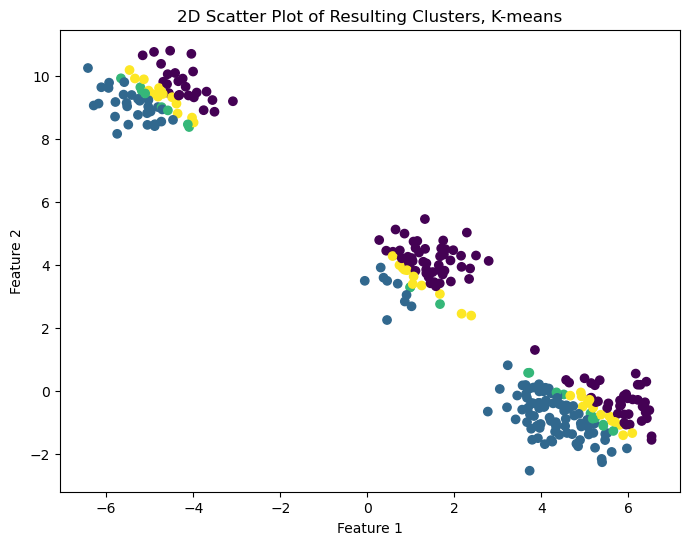

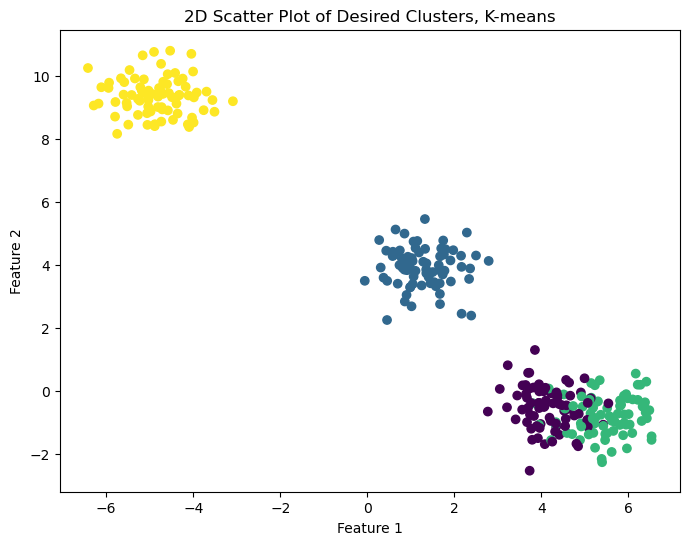

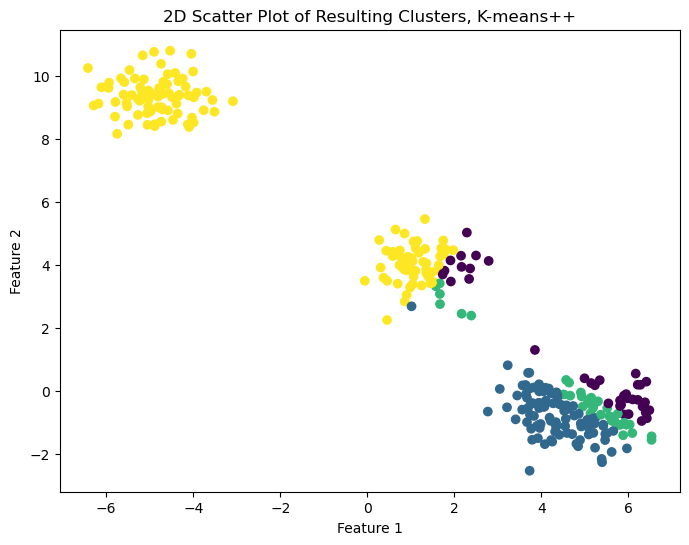

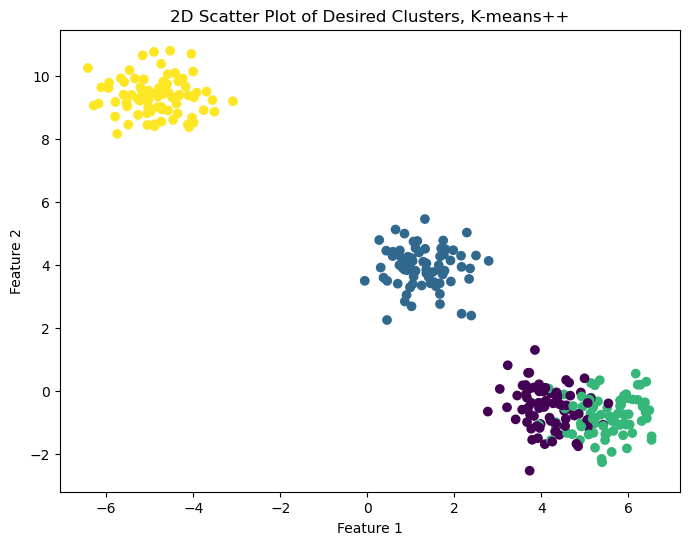

In [13]:
X, y = make_blobs(n_samples = 300, centers = 4, cluster_std = 0.6, random_state = None)

kmeanss = Kmeans(X, 4, 0.000001)

kmeanss.kmeans(y)
kmeanss.kmeanspp(y)

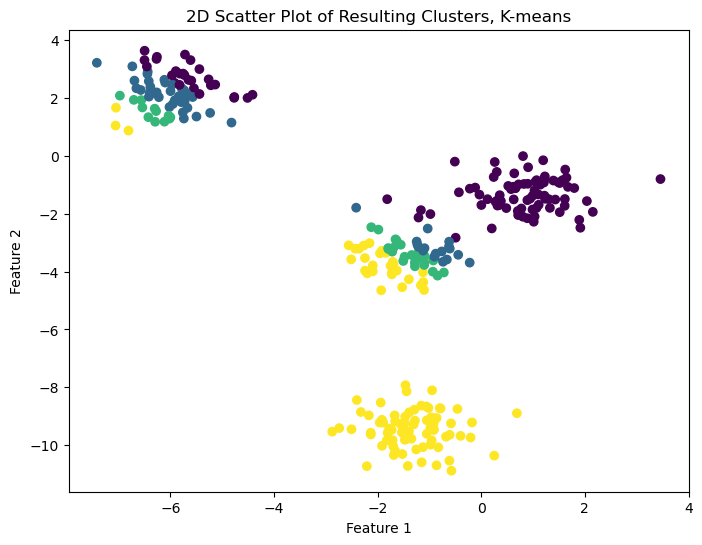

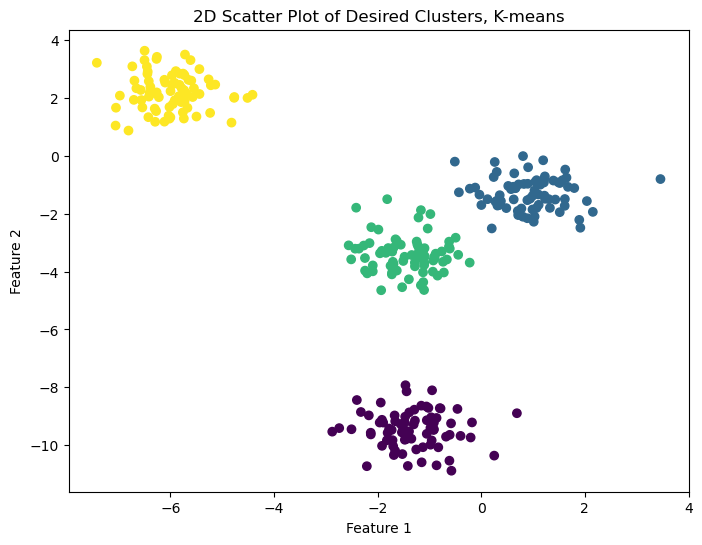

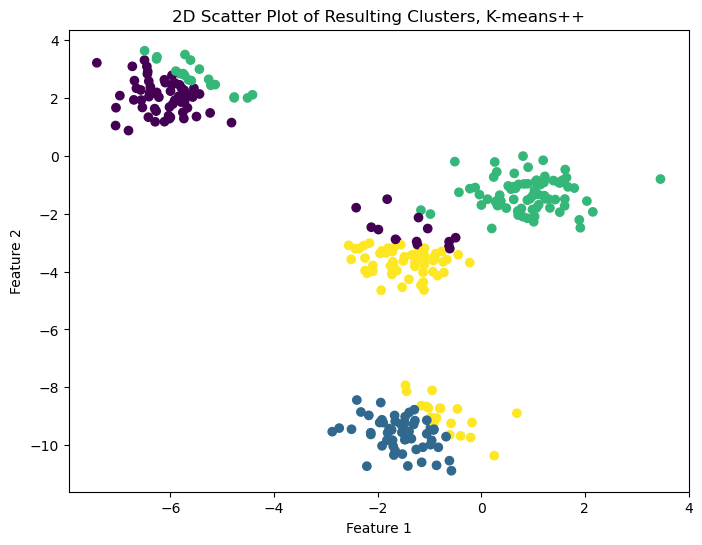

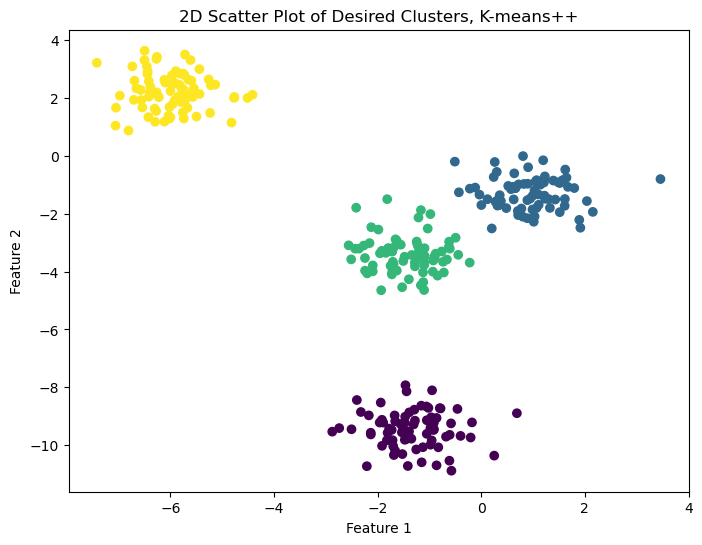

In [14]:
X, y = make_blobs(n_samples = 300, centers = 4, cluster_std = 0.6, random_state = 2)

kmeanss = Kmeans(X, 4, 0.000001)

kmeanss.kmeans(y)
kmeanss.kmeanspp(y)

### Comparing results from different seeds:
Seed = 2 seems to give pleasant results. I feel like the random seed sometimes sees a completely different way of clustering that is not necessarily not valid, but just doesn't fit the expected labels.

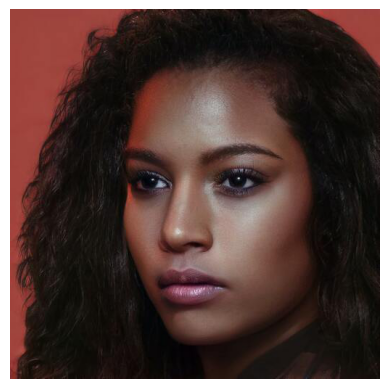

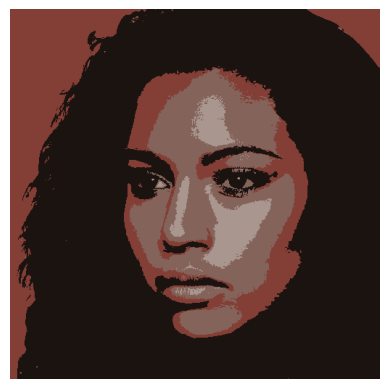

In [18]:
img = cv2.imread('../data/proj4/cropped.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
shape = img_rgb.shape
plt.imshow(img_rgb)
plt.axis('off')
plt.show()
img_rgb = img_rgb.reshape(-1, 3)

kme = Kmeans(img_rgb, 4, 0.000001)
kme.kmeanspp_centers()
kme.recursive()

img_rgb_edit = kme.recolor().reshape(shape)

plt.imshow(img_rgb_edit)
plt.axis('off')
plt.show()

### Comparing all results from different methods and seeds:
K-means++ does not always provide better results, but it usually does at least. If the clusters are not very separate, both K-means and K-means++ don't provide nice clusters. But both are working fine for most seeds. K-means++ is much better at not having mixed clusters, although it causes two clusters to be the same sometimes.

## Hierarchical

In [8]:
class Hierarchical:
    def __init__(self, X):
        self.X = X
        self.clusters = [np.array(c) for c in X]
        self.matrix = []
        self.clustersid = list(range(len(self.clusters)))

    def merge(self, clusterA_id, clusterB_id):
        clusterA = self.clusters[clusterA_id]
        clusterB = self.clusters[clusterB_id]

        min_dist = self.ward_distance(clusterA_id, clusterB_id)

        self.clusters.append(np.vstack([clusterA, clusterB]))
        self.clusters[clusterA_id] = None
        self.clusters[clusterB_id] = None
        self.clusters = [cluster for cluster in self.clusters if cluster is not None]

        self.clustersid.append(max(self.clustersid) + 1)

        clusterA_id_new = self.clustersid[clusterA_id]
        clusterB_id_new = self.clustersid[clusterB_id]

        self.clustersid[clusterA_id] = -1
        self.clustersid[clusterB_id] = -1
        
        self.clustersid = [id for id in self.clustersid if id != -1]

        self.matrix.append([clusterA_id_new, clusterB_id_new, np.sqrt(min_dist), 0])

    def ward_distance(self, clusterA_id, clusterB_id):
        clusterA = self.clusters[clusterA_id]
        clusterB = self.clusters[clusterB_id]

        if clusterA.ndim == 1:
            centroidA = clusterA
        else:
            centroidA = np.mean(clusterA, axis = 0)
        
        if clusterB.ndim == 1:
            centroidB = clusterB
        else:
            centroidB = np.mean(clusterB, axis = 0)

        sizeA = len(clusterA)
        sizeB = len(clusterB)
        centroid_distance = np.sum((centroidA - centroidB) ** 2)

        return (sizeA * sizeB) / (sizeA + sizeB) * centroid_distance

    def recursive(self):
        while len(self.clusters) > 1:
            min_dist = float("inf")
            i_max, j_max = 0, 0
            for i in range(len(self.clusters)):
                for j in range(i + 1, len(self.clusters)):
                    dist = self.ward_distance(i, j)
                    if(dist < min_dist):
                        min_dist = dist
                        i_max, j_max = i, j
            self.merge(i_max, j_max)

    def hierarchical(self):
        self.recursive()
        den = sch.dendrogram(np.array(self.matrix))

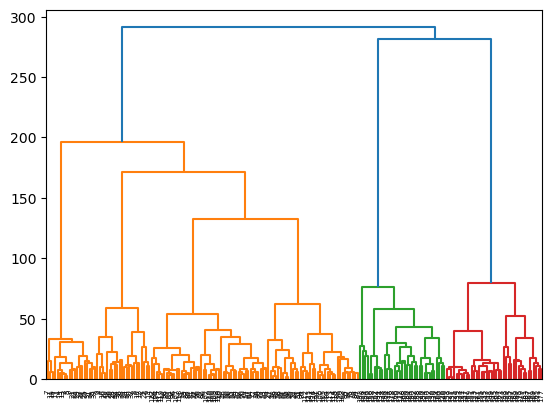

In [ ]:
df = pd.read_csv('../data/proj4/Mall_Customers.csv')
with pd.option_context('future.no_silent_downcasting', True):
    df["Gender"] = df["Gender"].replace(to_replace = ['Male', 'Female'], value = [-1, 1]).infer_objects()
df = df.drop('CustomerID', axis = 1)
df = df.to_numpy()

hier = Hierarchical(df)
hier.hierarchical()